In [4]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

Funkcje do wyświetlania obrazów w skali szarości i RGB:

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    plt.show()

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    plt.show()

  * W TensorFlow każdy obraz wejściowy jest zwykle reprezentowany jako tensor 3D o kształcie 

```python
[wysokość, szerokość, kanały].
```

  * Mini-batch jest reprezentowana jako tensor 4D kształtu

```python
[wielkość mini-partii, wysokość, szerokość, kanały].
```
  * Wagi warstwy splotowej są przedstawione jako tensor 4D kształtu . 

```python
[f_h, f_w, f_n, f_n']
```

Spójrzmy na prosty przykład. 

  * Poniższy kod ładuje dwa przykładowe obrazy za pomocą 
    ```python
    load_sample_images() 
    ```
  * Następnie tworzy dwa filtry $7 x 7$ (jeden z pionową białą linią pośrodku, a drugi z poziomą białą linią) i stosuje je do obu obrazów za pomocą warstwy splotowej zbudowanej za pomocą funkcji 
    ```python
    conv2d ()
    ```
    z TensorFlow (z zerowym padding-em i stride równym 2). 
  * W końcu, rysuje jedną z wynikowych **feature maps**.

Troszkę o funkcji **conv2d()** :
  * **X** jest wejściową mini-bach (tensor 4D).
  * **filters** to zestaw filtrów do zastosowania (także tensor 4D)
  * **strides** jest czteroelementową tablicą 1D, w której 
    * dwa centralne elementy to pionowy i poziomy *strides* ($s_h$ i $s_w$). 
    * Pierwszy i ostatni element musi być równy 1. 
    W przyszłości zostaną użyte jako **batch stride**
      * **strides** wsadu (aby pominąć niektóre instancje) 
      * **strides** kanału (aby pominąć niektóre z **feature maps** lub warstw).
  * **padding** musi być ustawiony na **"VALID"** lub **"SAME"**:
    * Jeśli jest ustawiona na **"VALID"**, warstwa splotowa nie używa wypełnienia zerami i może zignorować niektóre wiersze i kolumny w dolnej i prawej części obrazu wejściowego.
    * Jeśli ustawione na **"SAME"**, warstwa splotowa używa w razie potrzeby zerowego wypełnienia. W tym przypadku liczba neuronów wyjściowych jest równa liczbie neuronów wejściowych podzielonych przez krok zaokrąglonych w górę.

In [9]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape
print("Batch size", batch_size)
print("Height ", height)
print("Width ", width)
print("channels ", channels)

Batch size 2
Height  427
Width  640
channels  3


In [10]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

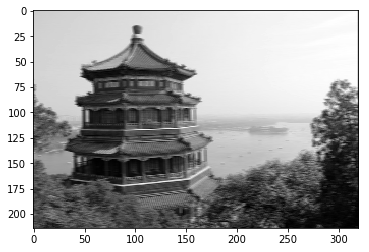

In [14]:
tf.reset_default_graph()

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

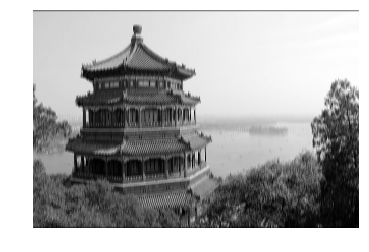

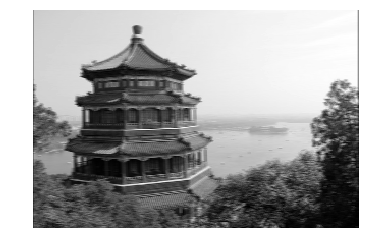

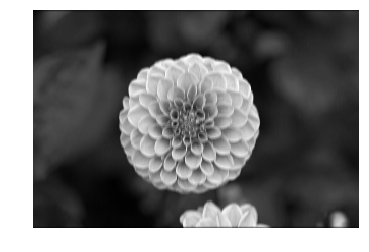

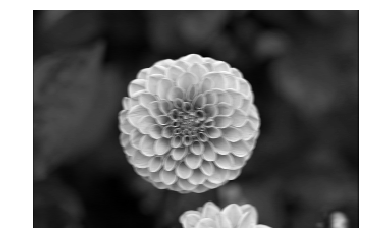

In [13]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

# Przykład

Można wykonać analogiczna zadanie za pomocą 

```python
tf.layers.conv2d()
```

In [15]:
tf.reset_default_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2], padding="SAME")

In [16]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

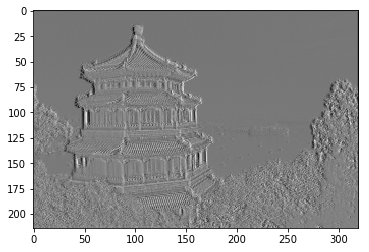

In [17]:
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

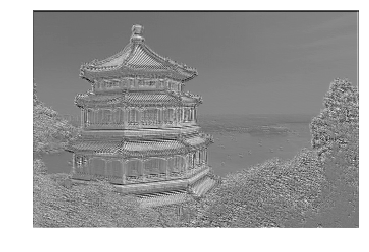

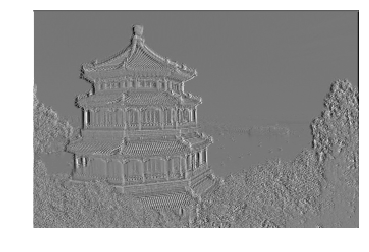

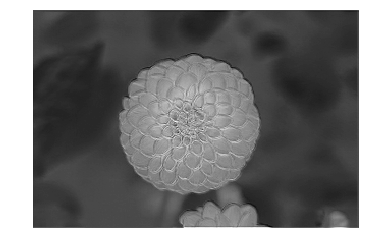

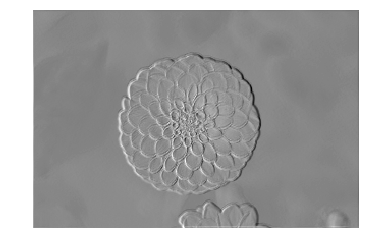

In [18]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

# VALID vs SAME padding

In [25]:
tf.reset_default_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))

filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print(x.eval())
    print(filters.eval())
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

[[[[ 1.]
   [ 2.]
   [ 3.]
   [ 4.]
   [ 5.]
   [ 6.]
   [ 7.]
   [ 8.]
   [ 9.]
   [10.]
   [11.]
   [12.]
   [13.]]]]
[[[[ 2.]]

  [[ 3.]]

  [[ 5.]]

  [[ 7.]]

  [[11.]]

  [[13.]]]]
VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


# Pooling layer

In [26]:
batch_sizebatch_si , height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

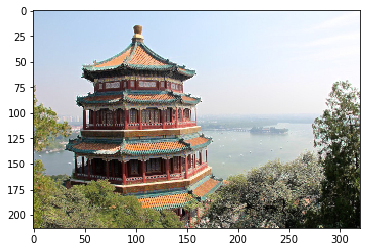

In [27]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

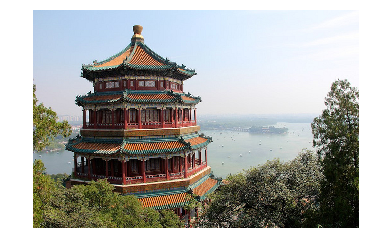

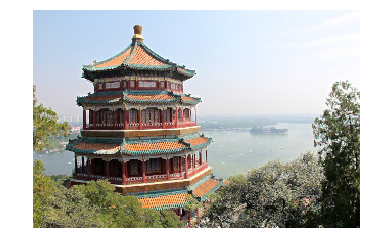

In [30]:
plot_color_image(dataset[0])
plt.show()
    
plot_color_image(output[0])
plt.show()